In [1]:
from data import generate_batches
from data import prepare_data
from data import read_test

from model.encoder import Encoder
from model.decoder import Decoder_luong
from model.gcn import Gcn

from BLEU import BLEU

from utils import time_since

from evaluator import Evaluator

import torch
import torch.nn as nn
from torch.nn import functional
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import numpy as np
import time
import random
import os

#from validation import Evaluator

%load_ext autoreload
%autoreload 2

In [2]:
USE_CUDA = True
MAX_LENGTH = 100
DIR_FILES = 'data/disambiguation/sense-eval2/'
DIR_TRAIN = os.path.join(DIR_FILES, 'train')
DIR_TEST = os.path.join(DIR_FILES, 'test')
DIR_RESULTS = 'results/step_1'
SPLIT_TRAIN = 0.7
SPLIT_VALID = 0.15
# The rest is for test

# Reading the data

In [3]:
input_lang, output_lang, train_syntax, test_syntax, pairs_train, pairs_test= prepare_data(max_length=MAX_LENGTH, dir_train=DIR_TRAIN, dir_test=DIR_TEST, return_trees=True)

Reading lines...
Read 9080 train pairs
Read 4151 test pairs
Filtered to 9058 pairs
Creating vocab...
Creating matrixes...
Indexed 28967 words in input language, 23810 words in output


In [5]:
pairs_train = np.array(pairs_train)


# Train

In [6]:
def train(input_batches, target_batches, input_matrixes,\
          encoder, decoder, gcn, criterion, batch_ix, train=True):
    
    if train and (batch_ix % batch_size) == 0:
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        gcn_optimizer.zero_grad()
        
    loss = 0
    
    encoder_hidden = encoder.init_hidden(1)
    encoder_outputs, encoder_hidden = encoder(input_batches, encoder_hidden)

    encoder_outputs = nn.ReLU()(gcn(encoder_outputs.squeeze(1), input_matrixes).unsqueeze(1))
    decoder_hidden = encoder_hidden
    #print(encoder_outputs.shape, state.shape)
    
    decoder_context = Variable(torch.zeros(1, 1))   
    #decoder_hidden = encoder_hidden
    # set the start of the sentences of the batch
    decoder_input = torch.LongTensor([input_lang.vocab.stoi['<sos>']] * 1)

    # store the decoder outputs to estimate the loss
    all_decoder_outputs = Variable(torch.zeros(target_batches.size()[0], 1, len(output_lang.vocab.stoi)))
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()
        decoder_context = decoder_context.cuda()  
    
    if train:
        use_teacher_forcing = random.random() < teacher_forcing_ratio
    else:
        use_teacher_forcing = False
    
    if use_teacher_forcing:        
        # Use targets as inputs
        for di in range(target_batches.shape[0]):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(
                decoder_input.unsqueeze(0), decoder_context, decoder_hidden, encoder_outputs)
            
            all_decoder_outputs[di] = decoder_output
            decoder_input = target_batches[di]
    else:        
        # Use decoder output as inputs
        for di in range(target_batches.shape[0]): 
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(
                decoder_input.unsqueeze(0), decoder_context, decoder_hidden, encoder_outputs) 
            
            all_decoder_outputs[di] = decoder_output
            
            # Greedy approach, take the word with highest probability
            topv, topi = decoder_output.data.topk(1)            
            decoder_input = Variable(torch.LongTensor(topi.cpu()).squeeze(dim=0))
            if USE_CUDA: decoder_input = decoder_input.cuda()
    
    loss = nn.NLLLoss()(all_decoder_outputs.view(-1, decoder.output_size), target_batches.contiguous().view(-1))          
    
    if train and (batch_ix % batch_size) == 0:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
        torch.nn.utils.clip_grad_norm_(gcn.parameters(), clip)
        encoder_optimizer.step()
        decoder_optimizer.step()
        gcn_optimizer.step()
    elif train:
        loss.backward()
    
    return loss.item() 

# Model

In [7]:
attn_model = 'general'
hidden_size = 256
emb_size = 300
n_layers = 2
dropout_p = 0.1
seed = 12
teacher_forcing_ratio = 0.5
clip = 5.0

n_epochs = 60
batch_size = 100

In [8]:
torch.manual_seed(seed)
np.random.seed(seed)

In [9]:
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class Gcn(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(Gcn, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.init_params()
        
    def init_params(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
            
    def forward(self, input, adj):
        # input: (seq_len x in_features)
        # adj: (seq_len x seq_len)
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [10]:
encoder = Encoder(len(input_lang.vocab.stoi), hidden_size, emb_size, n_layers, dropout_p, input_lang, USE_CUDA)
decoder = Decoder_luong(attn_model, hidden_size, len(output_lang.vocab.stoi), emb_size, 2 * n_layers, dropout_p, output_lang, USE_CUDA)
gcn = Gcn(hidden_size, hidden_size)

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    gcn = gcn.cuda()


In [83]:
learning_rate = 0.001
encoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, encoder.parameters()), lr=learning_rate)
decoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, decoder.parameters()), lr=learning_rate)
gcn_optimizer = optim.Adam(gcn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [25]:
# Keep track of time elapsed and running averages
start = time.time()
train_losses = []
validation_losses = []
validation_bleu = []

plot_every = 5
print_every = 5
validate_loss_every = 25
best_bleu = 0
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [ ]:
for epoch in range(1, n_epochs): 
    # Shuffle data
    #id_aux = np.random.permutation(np.arange(len(pairs_train)))
    #pairs_train = pairs_train[id_aux]
    
    # Get the batches for this epoch
    input_batches, input_matrixes, target_batches = generate_batches(input_lang, output_lang, 1, pairs_train, arr_dep=matrixes_train, USE_CUDA=USE_CUDA)    
    
    encoder.train()
    decoder.train()
    gcn.train()
    print_loss_total = 0
        
    for batch_ix, (input_var, input_matrix, target_var) in enumerate(zip(input_batches, input_matrixes, target_batches)):
        
        # Run the train function
        input_matrix = np.array(input_matrix[0])
        degree = np.array(np.sum(input_matrix, axis=0))
        degree = np.matrix(np.diag(degree))
        
        input_matrix = torch.FloatTensor(np.linalg.inv(degree) * input_matrix)
        if USE_CUDA:
            input_matrix = input_matrix.cuda()

        loss = train(input_var, target_var, input_matrix,\
                 encoder, decoder, gcn, criterion, batch_ix, train=True)
        #loss = train_luong(input_var, target_var, input_var.size(1), True)
            
        torch.cuda.empty_cache()

        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss

        if batch_ix == 0: continue            

        if batch_ix % (print_every * batch_size)  == 0:
            print_loss_avg = print_loss_total / (print_every * batch_size)
            print_loss_total = 0
            print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, batch_ix / len(input_batches) * 100, print_loss_avg)
            train_losses.append(loss)
            print(print_summary)
    
    input_batches, input_matrixes, target_batches = generate_batches(input_lang, output_lang, 1, pairs_test, arr_dep=matrixes_test, USE_CUDA=USE_CUDA)
    
    encoder.eval()
    decoder.eval()
    gcn.eval()
    
    with torch.no_grad():
        print_loss_total = 0
        for batch_ix, (input_var, input_matrix, target_var) in enumerate(zip(input_batches, input_matrixes, target_batches)):
    
            # Run the train function
            input_matrix = np.array(input_matrix[0])
            degree = np.array(np.sum(input_matrix, axis=0))
            degree = np.matrix(np.diag(degree))

            input_matrix = torch.FloatTensor(np.linalg.inv(degree) * input_matrix)
            if USE_CUDA:
                input_matrix = input_matrix.cuda()
            loss = train(input_var, target_var, input_matrix,\
                     encoder, decoder, gcn, criterion, batch_ix, train=False)

            print_loss_total += loss
            torch.cuda.empty_cache()
    val_loss = print_loss_total / len(input_batches)
    validation_losses.append(val_loss)
    
    evaluator = Evaluator(encoder, decoder, input_lang, output_lang, MAX_LENGTH, True)
    acc = evaluator.evaluate_acc(pairs_test, k_beams=1)
    if acc > best_acc:
        best_acc = acc
        torch.save(encoder.state_dict(), f'{DIR_RESULTS}/encoder.pkl')
        torch.save(decoder.state_dict(), f'{DIR_RESULTS}/decoder.pkl')
    validation_acc.append(acc)
    print(f'------------- acc: {acc}')

    # Prevent overflow gpu memory
    del evaluator

10m 7s (- 293m 26s) (1 1%) 8.8581
10m 47s (- 312m 53s) (1 2%) 7.6545
11m 22s (- 329m 48s) (1 3%) 7.6741
11m 59s (- 347m 49s) (1 4%) 7.4844
12m 36s (- 365m 33s) (1 5%) 7.7772
13m 25s (- 389m 6s) (1 6%) 7.1249
14m 12s (- 411m 56s) (1 7%) 6.8611
14m 51s (- 431m 6s) (1 8%) 6.7559
15m 27s (- 448m 13s) (1 9%) 6.9580
16m 0s (- 464m 5s) (1 10%) 6.7308
16m 32s (- 479m 45s) (1 11%) 6.9801
17m 9s (- 497m 22s) (1 12%) 6.7651
17m 48s (- 516m 14s) (1 13%) 6.7693
18m 19s (- 531m 20s) (1 14%) 6.7045
18m 51s (- 546m 53s) (1 16%) 6.6671
19m 23s (- 562m 25s) (1 17%) 6.2395
20m 7s (- 583m 45s) (1 18%) 6.1449
20m 58s (- 608m 20s) (1 19%) 6.1848
21m 49s (- 632m 48s) (1 20%) 6.2158
22m 38s (- 656m 47s) (1 21%) 6.2826
23m 25s (- 679m 30s) (1 22%) 6.1796
23m 58s (- 695m 6s) (1 23%) 6.2378
24m 47s (- 718m 53s) (1 24%) 6.1560
25m 29s (- 739m 7s) (1 25%) 6.1880
26m 6s (- 757m 12s) (1 26%) 6.0382
26m 48s (- 777m 21s) (1 27%) 5.9393
27m 24s (- 794m 41s) (1 28%) 5.9640
27m 58s (- 811m 6s) (1 29%) 5.9676
28m 28s (- 8

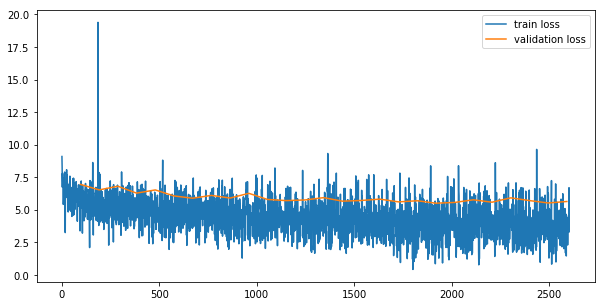

In [49]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=1) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
def plot_losses(train_loss, val_loss, scale):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss)
    plt.plot([(x + 1) * scale - 1 for x in range(len(val_loss))], val_loss)
    plt.legend(['train loss', 'validation loss'])

rcParams['figure.figsize'] = (15, 10)
plot_losses(train_losses, validation_losses, int(len(train_losses) / len(validation_losses)))

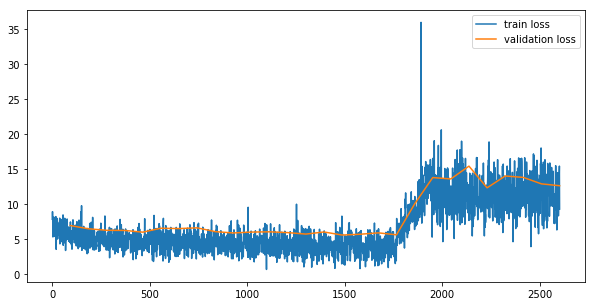

In [27]:
plot_losses(train_losses, validation_losses, int(len(train_losses) / len(validation_losses)))

In [ ]:
evaluator = Evaluator(encoder, decoder, input_lang, output_lang, 
                      MAX_LENGTH, USE_CUDA)
candidates, references = evaluator.get_candidates_and_references(pairs_test[:10000], k_beams=2)
len(candidates), len(references)

In [12]:
BLEU(candidates, [references]) 

(0.28063523097173265,
 [0.6573135078342698,
  0.37567686039915427,
  0.22488307382629802,
  0.13494545201862276],
 0.953820572858132)

In [11]:
train_losses

[9.041672706604004,
 7.149496555328369,
 14.810012817382812,
 12.101698875427246,
 9.06682014465332,
 7.260944366455078,
 6.044005393981934,
 6.0010833740234375,
 7.1673264503479,
 6.06639289855957,
 6.229933261871338,
 8.623738288879395,
 5.882908344268799,
 4.927737236022949,
 5.671040058135986,
 7.489520072937012,
 5.501565456390381,
 5.914140224456787,
 6.912267208099365,
 6.224165916442871,
 7.6937079429626465,
 6.377658843994141,
 8.010522842407227,
 8.193879127502441,
 7.284544944763184,
 4.864162445068359,
 6.447579860687256,
 6.805881977081299,
 5.03970193862915,
 6.144567012786865,
 5.522188186645508,
 6.3946533203125,
 7.317024230957031,
 7.084739685058594,
 4.866414546966553,
 4.8789286613464355,
 6.360021114349365,
 5.258521556854248,
 7.594843864440918,
 5.99109411239624,
 6.1218085289001465,
 4.6263885498046875,
 6.505831241607666,
 6.49678897857666,
 6.661844253540039,
 5.703457832336426,
 6.080120086669922,
 5.556210994720459,
 4.3718485832214355,
 7.616245269775391,
 

In [13]:
pairs_test[480]

array(["tom wasn 't convinced it was a good idea .",
       'tom no estaba convencido de que fuera una buena idea .'],
      dtype='<U245')

In [14]:
pairs_train[80000]

array(['just act as if nothing has happened .',
       'haga de cuenta que nada ha ocurrido .'],
      dtype='<U245')